# Assignment 8: Correlation Analysis and Hypothesis Testing

## Objective

The field of statistics is divided into two major parts: descriptive and inferential. In this assignment, we will cover two important topics in statistics: correlation analysis and hypothesis testing, where the former belongs to the descriptive part and the latter belongs to the inferential part. After this assignment, you will be able to answer the following questions:

**Correlation Analysis**
1. How to visualize the relationship between two variables?  
2. What is Pearson's correlation? How to compute it?
3. What is Spearman's rank correlation? How to compute it?
4. What's the difference between Pearson's correlation and Spearman's rank correlation? 


**Hypothesis Testing**
1. Why A/B testing?  
2. What is a permutation test? How to implement it?
3. What is p-value? How to avoid p-hacking? 
4. What is a chi-squared test? How to implement it?


In this assignment, you can use [pandas](https://pandas.pydata.org/) or PySpark to manipulate data, and use [matplotlib](https://matplotlib.org/) or [seaborn](seaborn.pydata.org) to make plots. 

## Part 1. Correlation Analysis

As a data scientist, you often face this kind of question: "Are A and B correlated?" For example, 

* Do Canadian Currency and Oil Price move together?
* Do Vancouver Housing Price and US Stock Market have any correlation?
* Are GPA and Gender independent? 

To answer these questions, you need to conduct correlation analysis. 

Imagine you are a data scientist working at a real-estate company. You download a dataset from [property_tax_report_2018.zip](property_tax_report_2018.zip). The dataset contains information on properties from BC Assessment (BCA) and City sources in 2018.  You can find the schema information of the dataset from this [webpage](http://data.vancouver.ca/datacatalogue/propertyTaxAttributes.htm). 

You may think that for a newly built house, it tends to have a higher price than the ones built decades ago. In this assignment, your first job is to figure out whether YEAR_BUILT and HOUSE_PRICE are correlated. 

We first load the data as a DataFrame. 

In [2]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib as mpl
import matplotlib.pyplot as plt
import statsmodels.api as sm

plt.rcParams["figure.figsize"] = (16,7)

/Users/mvachher/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
df = pd.read_csv("property_tax_report_2018.csv")

df['HOUSE_PRICE'] = df.apply(lambda x: (x['CURRENT_LAND_VALUE']+x['CURRENT_IMPROVEMENT_VALUE'])/1000000.0, axis = 1)

### Task A. Visualizations

Since the housing price varies a lot by locations, we will only consider the houses whose <font color='blue'>postcode starts with 'V6A'</font>. Furthermore, we remove the houses that were <font color='blue'>built before 1900</font>.

<img src="img/v6a.png", width=500/>

In the following, please make two subplots in one row. For the left subplot, it is a scatter plot with X = `YEAR_BUILT` and Y = `HOUSE_PRICE`; for the right subplot, it is a hexbin plot (gridsize = 20) with X = `YEAR_BUILT` and Y = `HOUSE_PRICE`.

#### Prep data

In [4]:
df_viz_rows = (df['PROPERTY_POSTAL_CODE'].str.startswith('V6A', na=False)) & (df['YEAR_BUILT'] >= 1900)
df_viz = df[df_viz_rows]
df_viz.shape

(4726, 29)

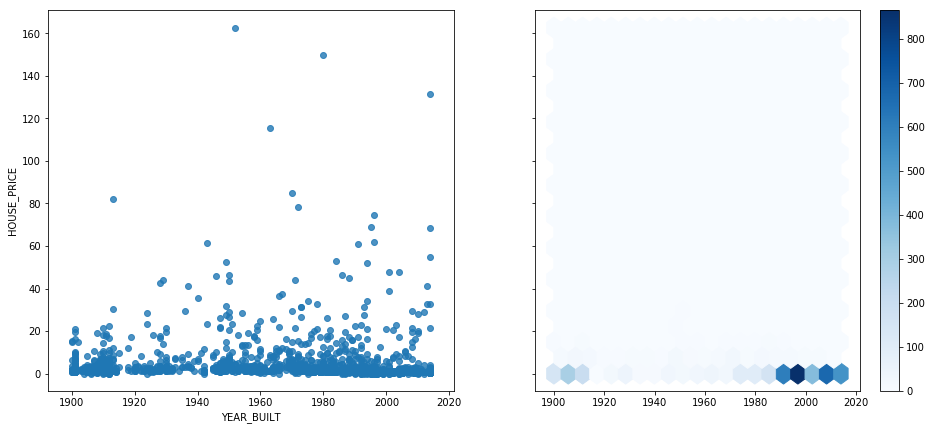

In [5]:
fig, axs = plt.subplots(ncols=2, sharex=True, sharey=True)
scatter_plt = sns.regplot(scatter=True, x='YEAR_BUILT', y='HOUSE_PRICE', data=df_viz, ax=axs[0], fit_reg=False)
hexbin_plt = axs[1].hexbin(df_viz['YEAR_BUILT'], df_viz['HOUSE_PRICE'], gridsize=20, bins=None, \
              cmap="Blues")
fig.colorbar(hexbin_plt, ax=axs[1])

Please write down the **two** most interesting findings that you draw from the plot.

**Findings**
1. Most properties in the area were reported around the late 1990s.
2. Majority of the properties cost is in the \$0 to $20mil range.

The above plots provide a general impression of the relationship between variables. There are some other visualizations that can provide more insight. One option is to bin one variable and plot percentiles of the other. 


In the following, please make three subplots in a row, where each subplot is a scatter plot with X = YEAR_BUILT and Y = HOUSE_PRICE. 
* The first subplot shows how the 25th percentile of `HOUSE_PRICE` changes over years (X = `YEAR_BUILT`, Y = `25TH_HOUSE_PRICE`); 
* The second subplot shows how the 50th percentile of `HOUSE_PRICE` changes over years (X = `YEAR_BUILT`, Y = `50TH_HOUSE_PRICE`); 
* The third subplot shows how the 75th percentile of `HOUSE_PRICE` changes over years (X = `YEAR_BUILT`, Y = `75TH_HOUSE_PRICE`);  


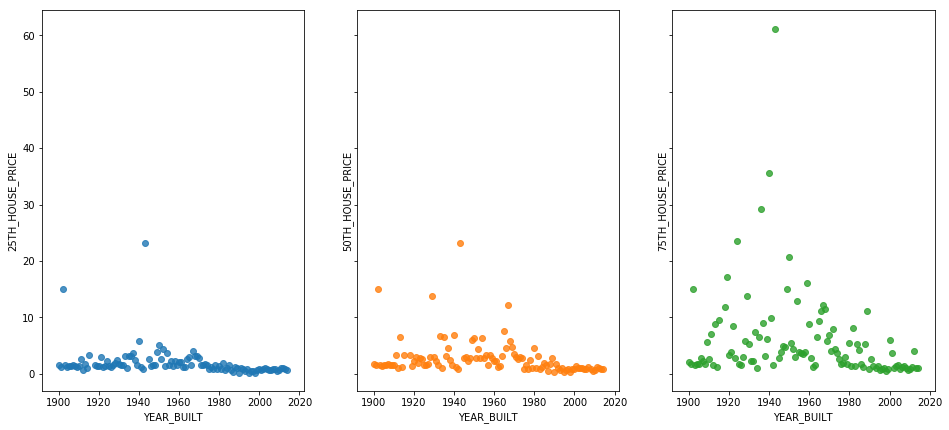

In [6]:
df_quantiles_25 = df_viz.groupby('YEAR_BUILT')['HOUSE_PRICE'].quantile(q=0.25, interpolation='nearest')
df_quantiles_50 = df_viz.groupby('YEAR_BUILT')['HOUSE_PRICE'].quantile(q=0.50, interpolation='nearest')
df_quantiles_75 = df_viz.groupby('YEAR_BUILT')['HOUSE_PRICE'].quantile(q=0.75, interpolation='nearest')

df_quantiles = pd.DataFrame({'25TH_HOUSE_PRICE': df_quantiles_25,
                             '50TH_HOUSE_PRICE': df_quantiles_50,
                             '75TH_HOUSE_PRICE': df_quantiles_75})
df_quantiles.reset_index(level=0, inplace=True)

fig, axs = plt.subplots(ncols=3, sharex=True, sharey=True)
scatter_plt_25 = sns.regplot(scatter=True, x='YEAR_BUILT', y='25TH_HOUSE_PRICE', \
                             data=df_quantiles, ax=axs[0], fit_reg=False)
scatter_plt_50 = sns.regplot(scatter=True, x='YEAR_BUILT', y='50TH_HOUSE_PRICE', \
                             data=df_quantiles, ax=axs[1], fit_reg=False)
scatter_plt_75 = sns.regplot(scatter=True, x='YEAR_BUILT', y='75TH_HOUSE_PRICE', \
                             data=df_quantiles, ax=axs[2], fit_reg=False)

Please write down the **two** most interesting findings that you draw from the plot.

**Findings**
1. The 25th Percentile values have a very less variation amongst them, which can be attributed to the domain problem. Most houses are supposed to be cheap owning to the economic and social structure of society.
2. There seems to be absurdly weird outlier in the 75th percentile values, specifically around the year 1940. This could potentially be due to misreporting the value or due to an economic boom in the region.

### Task B. Correlation Coefficient

A correlation coefficient is a numerical measure of some type of correlation, meaning a statistical relationship between a pair of variables. 

In the following, please compute the Pearson's correlation as well as Spearman's rank correlation for three pairs of variables: <`25TH_HOUSE_PRICE`, `YEAR_BUILT`>, <`50TH_HOUSE_PRICE`, `YEAR_BUILT`>, and <`75TH_HOUSE_PRICE`, `YEAR_BUILT`>, and then print out your results. 

Note that it is OK to use this [function](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.corr.html) to do this task, but make sure that you understand how the numbers are computed. 

In [19]:
print("Pearson-<25TH_HOUSE_PRICE,YEAR_BUILT>:",df_quantiles.corr(method='pearson')['YEAR_BUILT']['25TH_HOUSE_PRICE'])
print("Pearson-<50TH_HOUSE_PRICE,YEAR_BUILT>:",df_quantiles.corr(method='pearson')['YEAR_BUILT']['50TH_HOUSE_PRICE'])
print("Pearson-<75TH_HOUSE_PRICE,YEAR_BUILT>:",df_quantiles.corr(method='pearson')['YEAR_BUILT']['75TH_HOUSE_PRICE'])

Pearson-<25TH_HOUSE_PRICE,YEAR_BUILT>: -0.2549070441178994
Pearson-<50TH_HOUSE_PRICE,YEAR_BUILT>: -0.2626236505427194
Pearson-<75TH_HOUSE_PRICE,YEAR_BUILT>: -0.2280331661424261


In [20]:
print("Spearman-<25TH_HOUSE_PRICE,YEAR_BUILT>:",df_quantiles.corr(method='spearman')['YEAR_BUILT']['25TH_HOUSE_PRICE'])
print("Spearman-<50TH_HOUSE_PRICE,YEAR_BUILT>:",df_quantiles.corr(method='spearman')['YEAR_BUILT']['50TH_HOUSE_PRICE'])
print("Spearman-<75TH_HOUSE_PRICE,YEAR_BUILT>:",df_quantiles.corr(method='spearman')['YEAR_BUILT']['75TH_HOUSE_PRICE'])

Spearman-<25TH_HOUSE_PRICE,YEAR_BUILT>: -0.5429505564098134
Spearman-<50TH_HOUSE_PRICE,YEAR_BUILT>: -0.4766257145979762
Spearman-<75TH_HOUSE_PRICE,YEAR_BUILT>: -0.4106340132112355


Please write down the **two** most interesting findings that you draw from the result. 

**Findings**
1. As the Percentile increases, the prices start being less correlated (tending towards no correlation) with the year the property was built in.
2. All the Percentile prices are negatively correlated, that means that the prices tend to drop (in general) as and when years progress.

## Part 2. Hypothesis Testing

In many situations, we cannot get the full population but only a sample. If we derive an interesting result from a sample, how likely can we derive the same result from the entire population? In other words, we want to know whether this result is a true finding or it just happens in the sample by chance. Hypothesis testing aims to answer this fundamental question. 

### Task C. A/B Testing
> Acknowledgment: Thank [Greg Baker](http://www.cs.sfu.ca/~ggbaker/) for helping me to prepare this task.

A very common technique to evaluate changes in a user interface is A/B testing: show some users interface A, some interface B, and then look to see if one performs better than the other.

Suppose I started an A/B test on CourSys. Here are the two interfaces that I want to compare with. I want to know whether a good placeholder in the search box can attract more users to use the `search` feature.

<img src="img/ab-testing.png", width=800/>

The provided [searchlog.json](./searchlog.json) has information about users' usage. The question I was interested in: do people search more with the new design? (More precisely: is the number of searches per user different?)

To answer this question, we need to first pick up a **test statistic** to quantify how good an interface is. Here, we choose "the search_count mean". 

Please write the code to compute **the difference of the search_count means between interface A and Interface B.** 

In [9]:
import json

lst_dct = []

with open('searchlog.json', 'r') as f:
    for line in f:
        lst_dct.append(json.loads(line))

df_hypo = pd.DataFrame(lst_dct)

test_stat = df_hypo.groupby('search_ui')['search_count'].mean()

test_stat_res = test_stat['A'] - test_stat['B']
print("Difference of search_count means between interface A and interface B is:", test_stat_res)

Difference of search_count means between interface A and interface B is: -0.13500569535052287


Suppose we find that the mean value increased by 0.135. Then, we wonder whether this result is just caused by random variation. 

We define the Null Hypothesis as
 * The difference in search_count mean between Interface A and Interface B is caused by random variation. 
 
Then the next job is to check whether we can reject the null hypothesis or not. If it does, we can adopt the alternative explanation:
 * The difference in search_count mean  between Interface A and Interface B is caused by the design differences between the two.

We compute the p-value of the observed result. If p-value is low (e.g., <0.01), we can reject the null hypothesis, and adopt  the alternative explanation.  

Please implement a permutation test (numSamples = 10000) to compute the p-value. Note that you are NOT allowed to use an implementation in an existing library. You have to implement it by yourself.

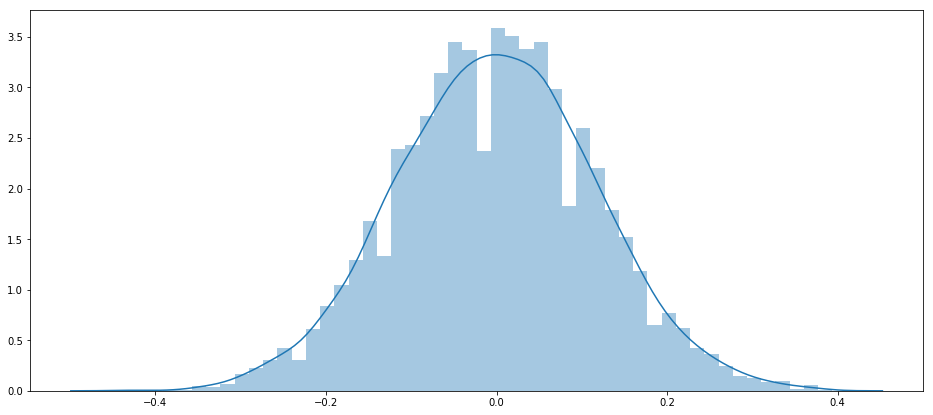

In [10]:
def perm_test(df, n=10000):
    exact_dist = []
    for i in range(n):
        df_tmp = df.copy()
        df_tmp['search_ui'] = df_tmp['search_ui'].sample(frac=1).reset_index(drop=True)
        test_stat = df_tmp.groupby('search_ui')['search_count'].mean()
        test_stat_res = test_stat['A'] - test_stat['B']
        
        exact_dist.append(test_stat_res)
    
    return exact_dist

resulting_dist = perm_test(df_hypo)
sns.distplot(resulting_dist)

In [12]:
# Performing a two-tailed test

left_tail = sum([1 for x in resulting_dist if x <= test_stat_res])
right_tail = sum([1 for x in resulting_dist if x >= abs(test_stat_res)])
p_val = (left_tail + right_tail)/len(resulting_dist)

print("p-value:", p_val)

threshold = 0.1

if p_val < threshold:
    print("\nWe reject Null Hypothesis. The difference in search_count mean between Interface A and Interface B is caused by the design differences between the two")
else:
    print("\nWe accept Null Hypothesis. The difference in search_count mean between Interface A and Interface B is caused by random variation.")

p-value: 0.2563

We accept Null Hypothesis. The difference in search_count mean between Interface A and Interface B is caused by random variation.


Suppose we want to use the same dataset to do another A/B testing. We suspect that instructors are the ones who can get more useful information from the search feature, so perhaps non-instructors didn't touch the search feature because it was genuinely not relevant to them.

So we decide to repeat the above analysis looking only at instructors.

**Q. If using the same dataset to do this analysis, do you feel like we're p-hacking? If so, what can we do with it? **

**A.** Yes, we are p-hacking. We could partition the entire dataset into 2 subsets X and Y. We'll then use X to formulate various null hypotheses for statistical testing and perform the tests on subset Y. We could also use Bonferroni correction to come about the other statistical tests we perform (dividing the threshold by the number of statistical tests conducted on the sets; produces absurdly low values of thresholds).

### Task D. Chi-squared test 

There are tens of different hypothesis testing methods. It's impossible to cover all of them in one week. Given that this is an important topic in statistics, I highly recommend using your free time to learn some other popular ones such as <a href="https://en.wikipedia.org/wiki/Chi-squared_test">Chi-Squired test</a>, <a href = "https://en.wikipedia.org/wiki/G-test">G-test</a>, <a href="https://en.wikipedia.org/wiki/Student%27s_t-test">T-test</a>, and <a href="https://en.wikipedia.org/wiki/Mann%E2%80%93Whitney_U_test">Mann–Whitney U test</a>.

On the searchlog dataset, there are two categorical columns: `is_instructor` and `search_ui`. In Task D, your job is to first learn how a Chi-Squired test works by yourself and then use it to test whether `is_instructor` and `search_ui` are correlated. 

Please write code to compute the contingency table, the chi-squared stat, the degrees of freedom, and the p-value. Note that unlike Task C, you can call any function in an existing library. But, please make sure to understand how those functions are implemented. 

In [13]:
tab = pd.crosstab(df_hypo['is_instructor'], df_hypo['search_ui'])
print("Contingency Table:")
print(tab)

Contingency Table:
search_ui        A    B
is_instructor          
False          233  213
True           115  120


In [14]:
table = sm.stats.Table(tab)
rslt = table.test_nominal_association()
print("Chi Squared Stat:", rslt.statistic)
print("Degrees of Freedom:", rslt.df)
print("p-value:", rslt.pvalue)

threshold = 0.1

if rslt.pvalue < threshold:
    print("\nWe reject Null Hypothesis. is_instructor and search_ui are independent.")
else:
    print("\nWe accept Null Hypothesis. is_instructor and search_ui are associated.")

Chi Squared Stat: 0.673174089127506
Degrees of Freedom: 1
p-value: 0.4119471591204329

We accept Null Hypothesis. is_instructor and search_ui are associated.


## Submission

Complete Tasks A-D in this [notebook](https://github.com/sfu-db/bigdata-cmpt733/blob/master/Assignments/A8/A8.ipynb), and submit it to the CourSys activity Assignment 8.